
## STOCHASTIC MODELING
MODULE 4 | LESSON 3


---

|  |  |
|:---|:---|
|**Reading Time** |  1h |
|**Prior Knowledge** |Linear Algebra, Maximum likelihood estimator, Monte Carlo  |
|**Keywords** |Markov Process, Markov chains, Transition Matrix


---

*In this notebook, we introduce Hidden Markov models in a reinforcement learning framework with Python.*

# **Hidden Markov Models**

## **1. Hidden Markov Models**

A Hidden Markov Model (HMM) is a Markov process that is split into two components: an observable component and an unobservable or "hidden" component that follows a Markov process. HMMs naturally describe setups where a stochastic system is observed through noisy measurements, for instance stock prices, that are affected by an unobserved economic factor. However, this type of modelization is of broad application in many fields, from speech recognition to thermodynamics.

A basic HMM contains the following components:
* A set of $N$ states $\mathcal{S}=\{s_1,...,s_N\}$
* A transition probability matrix $P$
* A sequence of $T$, possibly vector-valued, observations $\mathcal{Y}_T=\{y_1,...,y_T\}$
* A sequence of observation marginal likelihoods $f(y_t|s_t=i)$ for each $i=1,..,N$.
* An initial probability distribution $\pi=\{\pi_1,...,\pi_N\}$.

An important assumption is that the hidden Markov process is independent of past observations $\mathcal{Y}_{t-1}$, i.e., $\mathbb{P}\{s_t=j|s_t=i,\mathcal{Y}_{t-1}\}=\mathbb{P}\{s_t=j|s_t=i\}=p_{ij}$. 

This type of setup is also labeled in some instances as a Markov regime-switching model, where the observable output $y_t$ features a marginal distribution whose parameters change with the realization of an unobservable state. Let's see with an example an application of Hidden Markov Process.

Suppose that $y_t=\mu_t+\varepsilon_t$, where $\mu_t = \mu_j$ if $s_t=j$, $\mathcal{S}=\{1,...N\}$, $S_t$ is Markovian, and $\varepsilon_t$ is i.i.d. $N(0,\sigma^2)$. 

We are interested in making inference about the probability of being in each state $s_i$ at each date $t$, as well as estimating the model parameters of the transition matrix $P$ and the vector $(\mu_1,...,\mu_N,\sigma)$. We collect all the parameters in a vector $\theta$ and let's assume for now that we know its value with certainty.

Let's build the log-likelihood function of the process:
$$
\begin{align}
\mathcal{L}(\theta) = \sum_{t=1}^T log\ f(y_t|\mathcal{Y}_{t-1};\theta)
\end{align}
$$
where
$$
\begin{align}
f(y_t|\mathcal{Y}_{t-1};\theta) = \sum_{i=1}^N \mathbb{P}(s_t=i|\mathcal{Y}_{t-1};\theta) \times \phi_{t}(i)
\end{align}
$$
where $\phi_{t}(i)=\phi\left(\frac{y_t-\mu_i}{\sigma}\right)$, and $\phi(.)$ denotes the standard normal probability density function. The main problem arises from the evaluation of $\mathbb{P}(s_t=i|\mathcal{Y}_{t-1};\theta)$, which would usually require an overwhelming amount of computations for each potential path $\mathcal{Y}_{t-1}$ and for each period $t$. This rules out estimating directly $\theta$ by Maximum Likelihood.

One potential algorithm to reach a solution is to denote $\xi_{t|t}(j)=\mathbb{P}(s_t=j|\mathcal{Y}_{t};\theta)$. To estimate the model, we can rely on a recursive algorithm that sets the optimal forecasts $\xi_{t+1|t}(j)=\mathbb{P}(s_{t+1}=j|\mathcal{Y}_{t};\theta)$:
$$
\begin{align}
& \xi_{t|t}(i) = \frac{\xi_{t|t-1}(i)\phi_{t}(i)}{f(y_{t}|\mathcal{Y}_{t-1};\theta)} \\
& \xi_{t+1|t}(j) = \sum_{i=1}^N p_{ij} \xi_{t|t}(i)
\end{align}
$$
This procedure is named the Hamilton filter, developed by Hamilton (1990). To initialize the recursion, we can set $\xi_{1|0}(i)=1/N$ or, if we have some guess for the initial distribution, $\xi_{1|0}(i)=\pi_i$. Another alternative is to include it in the vector of parameters to estimate, under the usual constraints for a probability distribution.

Then, to estimate the model, we would set initial parameters $\theta^0$ that would allow us to recover each $\xi_{t+1|t}(j)$ and evaluate the log-likelihood function, then iterate with new guess $\theta^1$ and so on until convergence.

Lastly, notice that we can make forecasts on the observable process $y_{t+1}$ by exploiting the expressions for $\xi_{t+1|t}(j)$ once we have estimated the model parameters.

We are going to bring to practice this estimation by simulating a time series governed by a hidden Markov process. We first build a simulated time series and then estimate the model by maximum likelihood, applying the Hamilton filter within the evaluation step. To keep things manageable, we are going to assume that the value of $\sigma$ is known. Therefore, we just need to estimate the vector $\theta=\{\mu_1,\mu_2,p_{11},p_{22}\}$.

[ 0.86409275  1.64500383  0.88388044  1.21434147  0.63848057  1.19533836
  1.82984096  1.43696054  0.40989405  0.89555769  0.72516455  0.37356002
  0.36161959  1.94057817 -0.44588662]


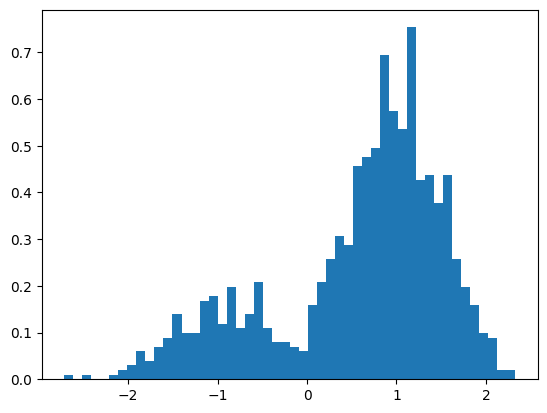

In [1]:
# Brute force estimation following the algorithm above for a simple case

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
from numpy.random import rand, seed
from scipy.stats import norm

# Generate simulations
# Assume a 2-state hidden Markov process

P = np.zeros((2, 2))

P[0, 0] = 0.45
P[0, 1] = 1.0 - P[0, 0]
P[1, 1] = 0.85
P[1, 0] = 1.0 - P[1, 1]

seed(12345)

LEN_HIST = 1500
SIGMA = 0.5
BURNIN = 500
# ACTUAL OBSERVED SAMPLE
T_SAMPLE = LEN_HIST - BURNIN

##
states_st = np.zeros((LEN_HIST), np.int8)
states_vt = np.zeros((LEN_HIST))
Yarray = np.zeros(T_SAMPLE)

S_DICT = dict(
    [
        (
            "1",
            0,
        ),
        ("2", 1),
    ]
)
S_VAL = dict(
    [
        (
            "1",
            -1,
        ),
        ("2", 1),
    ]
)

# Generate sequence of uniform random numbers
randarray = rand(LEN_HIST)
rnandarray = np.random.normal(0.0, SIGMA, size=LEN_HIST)
# Initialize process s_0, say at state 1 (0 in Python's vector notation)
states_st[0] = S_DICT["1"]
states_vt[0] = S_VAL["1"]
tt2 = 0
# print(states[0])
for tt in range(1, LEN_HIST):
    if P[states_st[tt - 1], states_st[tt - 1]] > randarray[tt]:
        states_st[tt] = states_st[tt - 1]
        states_vt[tt] = states_vt[tt - 1]
    else:
        if states_st[tt - 1] == S_DICT["1"]:
            states_st[tt] = S_DICT["2"]
            states_vt[tt] = S_VAL["2"]
        else:
            states_st[tt] = S_DICT["1"]
            states_vt[tt] = S_VAL["1"]
    if tt >= BURNIN:
        Yarray[tt2] = states_vt[tt] + rnandarray[tt]
        tt2 = tt2 + 1

print(Yarray[0:15])

count, bins, ignored = plt.hist(Yarray, 50, density=True)
plt.show()

After creating the time series, we define the functions that are needed to estimate the model.<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [2]:
# Define functions

# Hamilton filtering


def forward_alg(pi0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    y_like = likelihood(pi0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma)
    xi_prob_t[0, :] = np.multiply(pi0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma)
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

        # print(mu, phi, Y[tt-1], Y[tt], xi_prob[tt,:])

    return xi_prob_t, xi_prob_t1


def likelihood(xi_prob, mu, sigma, y):
    phi = norm.pdf((y - mu) / sigma)
    y_like = np.dot(xi_prob, phi)

    return y_like


def log_likelihood(theta, pi0, sigma, T, Y):
    # 0. Rearrange vector of parameters

    print(theta)

    P = np.zeros((2, 2))
    P[0, 0] = theta[0]
    P[0, 1] = 1 - P[0, 0]
    P[1, 1] = theta[1]
    P[1, 0] = 1 - P[1, 1]

    mu = theta[2:4]

    # 1. Forward algorithm

    xi_prob_t, xi_prob_t1 = forward_alg(pi0, 2, T, P, mu, sigma, Y)

    # print(xi_prob)

    # 2. Evaluate likelihood

    y_like = np.zeros(T)
    y_like[0] = likelihood(pi0, mu, sigma, Y[0])
    for tt in range(1, T):
        y_like[tt] = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])

    sum_log_like = -np.sum(np.log(y_like))
    # print(sum_log_like)

    return sum_log_like

Try and test the performance of the forward algorithm and the evaluation of the likelihood function:

In [3]:
# Set guess of initial distribution and vector of mu's
pi0 = [0.4, 0.6]
mu = [-2, 2]
xi_prob_t, xi_prob_t1 = forward_alg(pi0, 2, T_SAMPLE, P, mu, SIGMA, Yarray)
print(xi_prob_t)

# Test Log likelihood evaluation
y_like = likelihood(xi_prob_t[20, :], mu, SIGMA, Yarray[20])
theta = np.reshape(P, 2 * 2)
theta = np.append(theta, mu, axis=0)
theta = np.append(theta, [SIGMA], axis=0)

sum_log_like = log_likelihood(theta, pi0, 2, T_SAMPLE, Yarray)

print(sum_log_like)

[[6.60050358e-07 9.99999340e-01]
 [6.54659785e-13 1.00000000e+00]
 [1.27303954e-07 9.99999873e-01]
 ...
 [6.31715720e-12 1.00000000e+00]
 [9.03087044e-11 1.00000000e+00]
 [9.37388839e-09 9.99999991e-01]]
[ 0.45  0.55  0.15  0.85 -2.    2.    0.5 ]
1044.977919074794


Let's now estimate the model:

In [4]:
def log_likelihood_opt(pi0, sigma, T, Y):
    args = (pi0, sigma, T, Y)

    # Set bounds for parameters
    bounds = [(0.0, 1.0), (0.0, 1.0), (-2, 0), (0, 2)]

    result = sco.minimize(
        log_likelihood,
        np.array([pi0[0], pi0[1], -0.5, 0.5]),
        args=args,
        method="trust-constr",
        bounds=bounds,
        tol=1e-2,
    )

    return result


# Set guess of initial distribution and vector of mu's
pi0 = [0.4, 0.6]
mu = [-2, 2]

lik_model = log_likelihood_opt(pi0, SIGMA, T_SAMPLE, Yarray)

thetahat = lik_model.x

print(lik_model.x)

Phat = np.zeros((2, 2))

Phat[0, 0] = thetahat[0]
Phat[0, 1] = 1.0 - Phat[0, 0]
Phat[1, 1] = thetahat[1]
Phat[1, 0] = 1.0 - Phat[1, 1]

muhat = np.zeros((2))
muhat[0] = thetahat[2]
muhat[1] = thetahat[3]

xi_prob_t, xi_prob_t1 = forward_alg(pi0, 2, T_SAMPLE, Phat, muhat, SIGMA, Yarray)

print(xi_prob_t)

[ 0.4  0.6 -0.5  0.5]
[ 0.40000001  0.6        -0.5         0.5       ]
[ 0.4         0.60000001 -0.5         0.5       ]
[ 0.4         0.6        -0.50000001  0.5       ]
[ 0.4         0.6        -0.5         0.50000001]
[ 0.43642354  0.66582318 -0.67459322  0.97799336]
[ 0.43642356  0.66582318 -0.67459322  0.97799336]
[ 0.43642354  0.66582319 -0.67459322  0.97799336]
[ 0.43642354  0.66582318 -0.67459324  0.97799336]
[ 0.43642354  0.66582318 -0.67459322  0.97799337]
[ 0.43571151  0.78287301 -0.75974421  1.045785  ]
[ 0.43571152  0.78287301 -0.75974421  1.045785  ]
[ 0.43571151  0.78287303 -0.75974421  1.045785  ]
[ 0.43571151  0.78287301 -0.75974423  1.045785  ]
[ 0.43571151  0.78287301 -0.75974421  1.04578501]
[ 0.43087849  0.8567641  -0.84348534  1.03617451]
[ 0.4308785   0.8567641  -0.84348534  1.03617451]
[ 0.43087849  0.85676411 -0.84348534  1.03617451]
[ 0.43087849  0.8567641  -0.84348536  1.03617451]
[ 0.43087849  0.8567641  -0.84348534  1.03617452]
[ 0.42749092  0.85162146 -0.

Notice that the realized estimates are close to the actual values of the process. Still, for a relatively simple estimation, this "brute force" estimation faces difficulties at matching the actual dynamics of the underlying process. A crucial aspect lies in having good prior knowledge about the process at hand, which boils down to setting good initial conditions and bounds on the parameters.

We can visualize the output of the estimation. Zooming in on a particular subset of the sample, we can compare the estimated probability of each state of the hidden Markov process with the actual realizations of the state and the observable process.

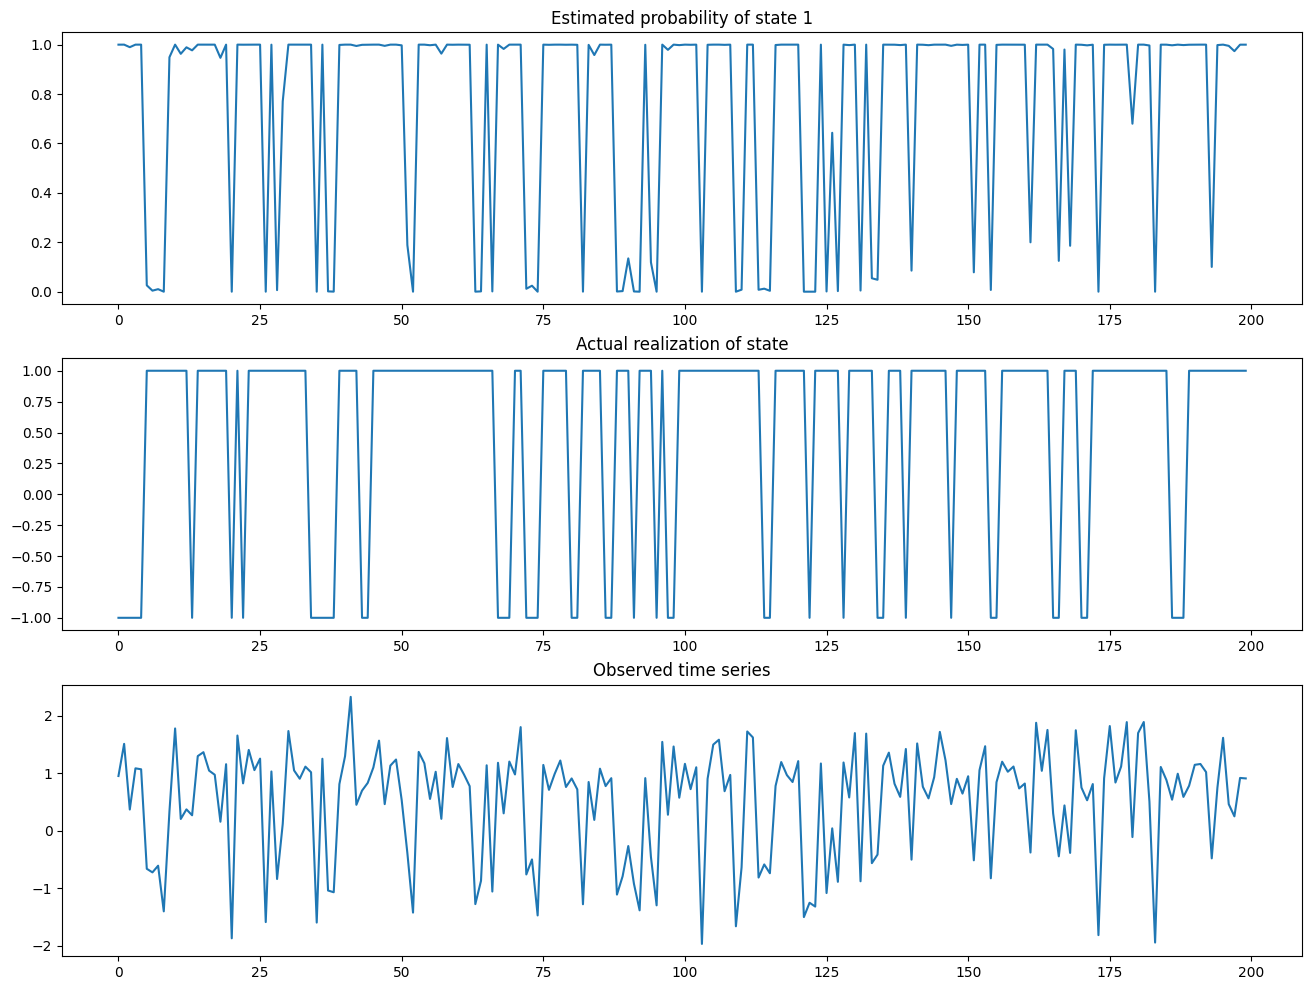

In [5]:
plt.subplot(3, 1, 1)
plt.plot(xi_prob_t[400:600, 1])
plt.title("Estimated probability of state 1")
plt.subplot(3, 1, 2)
plt.plot(states_vt[400:600])
plt.title("Actual realization of state")
plt.subplot(3, 1, 3)
plt.plot(Yarray[400:600])
plt.title("Observed time series")

fig = plt.gcf()
fig.set_size_inches(16, 12)
plt.show()

## **2. Conclusion**

In this lesson, we have worked through the concept of the Hidden Markov model and its practical application with Python. In the next lesson, we will apply these concepts to a real financial case study.

See you there!

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
